In [1]:
from fastai.vision import *
from sklearn.model_selection import train_test_split

from fastai_bayesian.custom_dropout import CustomDropout, switch_custom_dropout, convert_layers
from fastai_bayesian.metrics import (entropy, BALD, uncertainty_best_probability,
                      get_preds_sample, plot_hist_groups, top_k_uncertainty)

import seaborn as sns

In [2]:
class ImageActiveLearner:
    def __init__(self,path,train_df,get_model,acq_fn=None,label_fn=None,**kwargs):
        """Initialiaze the Learner with the train and test data, and create it with the given params. 
        data_params are the parameters of the TabularDatabunch.
        learn_params are the parameters of the tabular learner other than the Databunch.
        acq_fn is the acq_fn to use. Its signature is :
        acq_fn(learn:Learner,k)
        
        label_fn()
        
        """
        self.path = path
        
        # We store the functions we will use
        self.acq_fn = acq_fn
        self.label_fn = label_fn
        self.get_model = get_model
        
        # Create the Learner
        self.add_learn(train_df,**kwargs)
    
    @classmethod
    def create_databunch(cls,df,valid_pct = 0.2,bs = 32,size = 28,gray = True):
        path = Path("/")

        tfms = get_transforms(do_flip = False)

        data = (ImageList.from_df(df,path)
                .split_by_rand_pct(valid_pct=valid_pct,seed=42)
                .label_from_df()
                .transform(tfms,size = size)
                .databunch(bs = bs)
                .normalize())

        def get_one_channel(batch):
            x,y = batch
            return x[:,0,:,:].unsqueeze(1),y
        get_one_channel._order = 99

        if gray:
            data.add_tfm(get_one_channel)
        data.path = Path()

        return data
        
    def add_learn(self,train_df,**kwargs):

        # Create a Learner 
        path = self.path
        train_data = ImageActiveLearner.create_databunch(df=train_df, **kwargs)
        model = self.get_model()
        learn = Learner(train_data,model,metrics=accuracy)
        
        # Add the Custom Dropout to do MC Dropout
        get_args = lambda dp : {"p" : dp.p}
        convert_layers(learn.model,nn.Dropout,CustomDropout,get_args)
        switch_custom_dropout(learn.model,True)
        
        self.learn = learn
        
    def fit(self,n_epoch,lr):
        """Train the model using one cycle policy and with the training params"""
        n_epoch = listify(n_epoch)
        lr = listify(lr)
        
        for n,l in zip(n_epoch,lr):
            self.learn.fit_one_cycle(n, l)
    
    def inspect(self):
        """Inspect the results of the learning"""
        pass
    
    def acquire(self,acq_df,k,bs=512):
        """Get indexes of the k most interesting labels to acquire from the test set"""
        
        # We add a acquisition Databunch
        acq_data = ImageActiveLearner.create_databunch(df=acq_df, valid_pct=0.,bs=bs)
        idx = self.acq_fn(self.learn,acq_data,k)
        
        return idx
    
    def validate(self,metric,test_df,bs=512,MC_dropout=False):
        """Return a validation score on the test set"""
        learn = self.learn
        
        test_data = ImageActiveLearner.create_databunch(df=test_df, valid_pct=0.,bs=bs)
        
        learn.data = test_data
        
        if MC_dropout:
            preds,y = get_preds_sample(learn,DatasetType.Fix)
            pred = preds.mean(dim=0)
        else:
            pred,y = learn.get_preds(DatasetType.Fix)
        
        score = metric(pred,y)
        return score
        
    def label(self,idx,acq_df):
        """Label the indexes of the acquisition dataset"""
        df_to_label = acq_df.iloc[idx]        
        labeled_df = self.label_fn(df_to_label)
        return labeled_df
    
    @classmethod
    def transfer_rows(cls,train_df,acq_df,idx):
        """Transfer the rows of the acq_df to the train_df"""
        rows = acq_df.iloc[idx]

        train_df = pd.concat([train_df,rows])
        acq_df = acq_df.drop(acq_df.index[idx])
        
        return train_df, acq_df

In [3]:
from torch.distributions import Bernoulli

class DropLinear(nn.Module):
    def __init__(self, in_features, out_features, dp=0.):
        """Wrapper of a linear layer with a dropout module"""
        super(DropLinear, self).__init__()

        self.dropout = CustomDropout(dp)
        self.W = nn.Linear(in_features=in_features,out_features=out_features)
        
        self._mask = None
    
    @classmethod
    def sample_mask(cls,p,n):
        """Returns the mask of the weights"""
        
        bn = Bernoulli(p)
        mask = bn.sample((n,1))
        
        return mask
    
    def sample(self):
        """Sample a mask from the dropout module and the weight matrix"""
        p = 1 - self.dropout.dp
        shape = self.W.weight.data.shape
        n = shape[0]
        
        mask = DropLinear.sample_mask(p,n)
        
        return mask
    
    def topk_sample(self,n:int,k:int,p:float):
        """Sample a mask where only the top k weights of the matrix are considered for the dropout.
        The other weights will be necessarily dropped.
        
        Args:
            n: Total number of weights
            k: Number of weights with the best magnitude to consider for the dropout
            p: Probability to keep a neuron
            
        Returns:
            A mask where only the top k neurons will be used to sample from
        """
        
        # We compute the indexes of the rows with highest norm
        norm = self.W.weight.data.norm(dim=1)
        idx = torch.topk(norm,k).indices
        
        # We create a mask with only zeros first
        mask = torch.zeros(n)
        
        # Then we eventually allow the top k neurons to be kept depending on p
        small_mask = DropLinear.sample_mask(p,k).view(-1)
        mask[idx] = small_mask
        
        return mask 
        
    def set_mask(self,mask):
        self._mask = mask
        
    def remove_mask(self):
        self._mask = None
    
    def forward(self, x):
        if torch.is_tensor(self._mask):
            # We fix the weights with respect to the mask
            weight = self.W.weight.data
            bias = self.W.bias.data
            
            # We normalize as during training by dividing by the probability to keep a neuron
            dp = self.dropout.dp
            p = 1 - dp
            
            mask = self._mask
            if len(mask.shape) == 1:
                mask = mask.view(-1,1)
                
            # We apply our mask to the weights 
            masked_weight = mask.to(weight.device) * weight
            z = F.linear(x,masked_weight,bias)
            
            # Because we manually mask our weights we need to divide by the probability to keep a neuron
            z = z / p
        else:
            # We keep the stochasticity here so we do as usual
            z = self.W(x)
            z = self.dropout(z)
        return z

In [4]:
def get_model():
    model = nn.Sequential(
        nn.Flatten(),
        DropLinear(784,512,0.7),
        nn.ReLU(),
        DropLinear(512,512,0.7),
        nn.ReLU(),
        DropLinear(512,512,0.7),
        nn.ReLU(),
        nn.Linear(512,10)
    )
    return model

In [5]:
def train_test_split_image(train_size):
    # Create two data bunchs, one for training the unsupervised model, one for testing
    # the results of the semi supervised model
    
    # We first load the whole data set 
    path = untar_data(URLs.MNIST)
    tfms = get_transforms(do_flip = False)
    data = (ImageList.from_folder(path/"training")
            .split_none()
            .label_from_folder()
            .transform()
            .databunch())

    # We then randomly select train_size samples from the whole MNIST and put in train
    # for the unsupervised, and semi supervised training, and the rest will be used 
    # as a test set for the semi supervised model evaluation
    
    n = len(data.train_ds.x.items)
    
    # We create two data frames which will be used to create the data bunches
    train_idx = np.random.choice(n,train_size,replace = False)
    x_train,y_train = data.train_ds.x.items[train_idx],data.train_ds.y.items[train_idx]
    train_df = pd.DataFrame({"name":x_train,"label":y_train})
    
    test_idx = np.array(list(set(np.arange(n)) - set(train_idx)))
    x_test,y_test = data.train_ds.x.items[test_idx],data.train_ds.y.items[test_idx]
    test_df = pd.DataFrame({"name" : x_test,"label":y_test})
    
    return train_df, test_df

In [6]:
path = untar_data(URLs.MNIST)

In [7]:
total_train_size = 50000

train_df, test_df = train_test_split_image(total_train_size)

In [8]:
data = ImageActiveLearner.create_databunch(train_df,bs=512)

In [32]:
model = get_model()
learn = Learner(data,model,metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


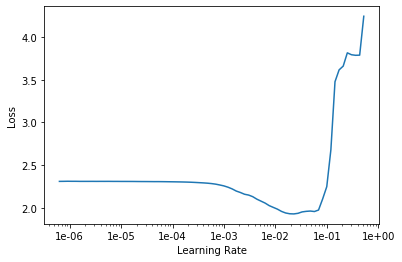

In [106]:
learn.lr_find()
learn.recorder.plot()

In [107]:
learn.fit_one_cycle(20,1e-2/2)

epoch,train_loss,valid_loss,accuracy,time
0,1.279325,0.551596,0.842400,00:17
1,0.690954,0.268827,0.921100,00:11
2,0.463190,0.238598,0.928400,00:11
3,0.411237,0.262793,0.923000,00:11
4,0.402150,0.234157,0.929100,00:11
5,0.403266,0.246488,0.926000,00:11
6,0.400598,0.286969,0.921500,00:12
7,0.399567,0.227984,0.938800,00:12
8,0.376658,0.236243,0.939900,00:11
9,0.367457,0.224974,0.939100,00:12


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


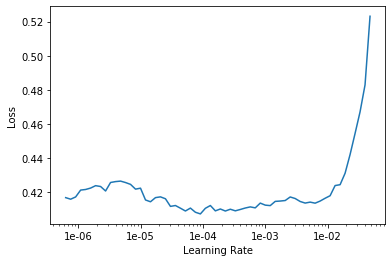

In [191]:
learn.lr_find()
learn.recorder.plot()

In [108]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.176191,0.109510,0.969600,00:12
1,0.184808,0.116177,0.971100,00:11
2,0.189888,0.117187,0.970200,00:11
3,0.190987,0.113121,0.966700,00:11
4,0.195815,0.113341,0.970600,00:11
5,0.180327,0.106683,0.971400,00:11
6,0.182702,0.099457,0.972700,00:11
7,0.172066,0.094839,0.974400,00:12
8,0.166393,0.103262,0.973800,00:11
9,0.164565,0.101989,0.973000,00:11


In [99]:
learn.save("model_dp_70")

In [33]:
learn.load("model_dp_70")

Learner(data=ImageDataBunch;

Train: LabelList (40000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
0,6,0,3,9
Path: /;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
6,4,6,1,6
Path: /;

Test: None, model=Sequential(
  (0): Flatten()
  (1): DropLinear(
    (dropout): CustomDropout(dp=0.7, activate_stochasticity=True)
    (W): Linear(in_features=784, out_features=512, bias=True)
  )
  (2): ReLU()
  (3): DropLinear(
    (dropout): CustomDropout(dp=0.7, activate_stochasticity=True)
    (W): Linear(in_features=512, out_features=512, bias=True)
  )
  (4): ReLU()
  (5): DropLinear(
    (dropout): CustomDropout(dp=0.7, activate_stochasticity=True)
    (W): Linear(in_features=512, out_features=512, bias=True)
  )
  (6): ReLU()
  (7): Linear(in_features=512, out_features=10, bias=True)
), opt_func=functools.partial

In [109]:
learn.save("model_dp_50")

In [100]:
learn.load("model_dp_50")

Learner(data=ImageDataBunch;

Train: LabelList (40000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
0,3,6,9,8
Path: /;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,7,1,4,2
Path: /;

Test: None, model=Sequential(
  (0): Flatten()
  (1): DropLinear(
    (dropout): CustomDropout(dp=0.5, activate_stochasticity=True)
    (W): Linear(in_features=784, out_features=512, bias=True)
  )
  (2): ReLU()
  (3): DropLinear(
    (dropout): CustomDropout(dp=0.5, activate_stochasticity=True)
    (W): Linear(in_features=512, out_features=512, bias=True)
  )
  (4): ReLU()
  (5): DropLinear(
    (dropout): CustomDropout(dp=0.5, activate_stochasticity=True)
    (W): Linear(in_features=512, out_features=512, bias=True)
  )
  (6): ReLU()
  (7): Linear(in_features=512, out_features=10, bias=True)
), opt_func=functools.partial

In [34]:
preds,y = get_preds_sample(learn)
pred = preds.mean(dim=0)
accuracy(pred,y)

tensor(0.9730)

In [16]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity,self).__init__()
        
    def forward(self,x):
        return x

def topk_sample_model(model,margin=0.05,set_mask=True):
    """Sample a mask for each Droplinear and set it"""
    masks = []
    for m in model:
        if isinstance(m,DropLinear):
            dp = m.dropout.dp
            p = 1-dp
            
            upper_p = p + margin
            scaled_p = p / (p + margin)

            n = m.W.weight.data.shape[0]
            k = int(upper_p * n)

            mask = m.topk_sample(n,k,scaled_p)
            if set_mask:
                m.set_mask(mask) 
            masks.append(mask)
    return masks

def sample_model(model,set_mask=True):
    """Sample a mask for each Droplinear and set it"""
    masks = []
    for m in model:
        if isinstance(m,DropLinear):
            mask = m.sample()
            if set_mask:
                m.set_mask(mask) 
            masks.append(mask)
    return masks

def get_mask_preds(learn,sample_model_fn,activ=None,ds_type=DatasetType.Fix):
    """Sample a mask and get preds"""
    mask = sample_model_fn(learn.model)
    pred,y = learn.get_preds(ds_type=ds_type,activ=activ)
    pred = pred.view((1,) + pred.shape)
    return mask,pred

def remove_lowest(masks,preds,score_fn,return_score=False):
    """Removes the lowest mask for a given score function"""
    scores = score_fn(preds)
    idx = scores.argmin().item()
    
    del masks[idx]
    del preds[idx]
    
    if return_score:
        return scores

def kls(preds):
    """Return the KL between the overall mean and the means without each mask"""
    mean_pred = torch.cat(preds).mean(dim=0)
    pred = torch.cat(preds)
    means_pred = (mean_pred[None] * T - pred)/ (T-1)

    logs = torch.log(mean_pred[None] / means_pred)

    kls = torch.einsum("tic,ic -> t",logs,mean_pred)
    
    return kls    

def MC_cross_entropy(x_logits,y_logits):
    """Computes the MC cross entropy"""
    T = y_logits.shape[0]
    
    normalized_logits = y_logits - torch.logsumexp(y_logits,dim=2,keepdim=True)
    log_y_prob = torch.logsumexp(normalized_logits,dim=0) - torch.log(torch.tensor(T).float())

    x_prob = torch.softmax(x_logits,dim=2).mean(dim=0)

    cross_entropy = (-x_prob * log_y_prob).sum(dim=1).mean(dim=0)
    return cross_entropy

def MC_entropy(x_logits):
    
    return MC_cross_entropy(x_logits,x_logits)

def MC_kl(x_logits,y_logits):
    cross_entropy = MC_cross_entropy(x_logits,y_logits)
    entropy = MC_entropy(x_logits)
    
    kl = cross_entropy - entropy
    
    return kl

In [76]:
current_masks = []
current_preds = []

mask,pred = get_mask_preds(learn)

current_masks.append(mask)
current_preds.append(pred)

T = 1
n_iterations = 10

total_mask = torch.cat(mask)

for t in range(T):
    masks = []
    preds = []
    for i in range(n_iterations):
        mask,pred = get_mask_preds(learn)
        mask = torch.cat(mask)
        
        masks.append(mask)
        preds.append(pred)
    
    import pdb
    pdb.set_trace()
    
    scores = kls(preds)
    masks = torch.cat(masks,dim=1)
    
    u = torch.clamp(masks + total_mask,0,1).sum(dim=0)
    i = (total_mask * masks).sum(dim=0)
    
    iou = i / u
    
    final_score = iou * scores
    best_idx = final_score.argmax().item()
    
    best_mask = masks[:,best_idx][:,None]
    best_pred = preds[best_idx]
    
    total_mask = torch.clamp(total_mask + best_mask,0,1)
    
    current_masks.append(best_mask)
    current_preds.append(best_pred)

> <ipython-input-76-f9e1faf63e42>(27)<module>()
-> scores = kls(preds)
(Pdb) n
> <ipython-input-76-f9e1faf63e42>(28)<module>()
-> masks = torch.cat(masks,dim=1)
(Pdb) scores
tensor([-inf, -inf, nan, -inf, -inf, -inf, -inf, -inf, -inf, -inf])
(Pdb) scores
tensor([-inf, -inf, nan, -inf, -inf, -inf, -inf, -inf, -inf, -inf])
(Pdb) preds
[tensor([[[0.0923, 0.0525, 0.0743,  ..., 0.0816, 0.2460, 0.1618],
         [0.0544, 0.0344, 0.0347,  ..., 0.0287, 0.5146, 0.1237],
         [0.1596, 0.0220, 0.0573,  ..., 0.0573, 0.2662, 0.1689],
         ...,
         [0.0866, 0.0622, 0.0824,  ..., 0.0648, 0.2785, 0.1392],
         [0.0669, 0.0461, 0.0522,  ..., 0.0432, 0.3651, 0.1524],
         [0.0519, 0.0390, 0.0324,  ..., 0.0228, 0.5522, 0.1034]]]), tensor([[[0.0738, 0.0563, 0.0492,  ..., 0.0659, 0.2965, 0.1893],
         [0.0605, 0.0365, 0.0434,  ..., 0.0304, 0.5244, 0.1076],
         [0.1691, 0.0268, 0.0551,  ..., 0.0395, 0.2681, 0.1597],
         ...,
         [0.0801, 0.0588, 0.0671,  ..., 0.0563, 

BdbQuit: 

In [13]:
from neptune.sessions import Session
import getpass

api_token = getpass.getpass("Please enter your NeptuneML API token : ")
session = Session(api_token=api_token)
project = session.get_project(project_qualified_name='danywin/EnsembleDropout')

Please enter your NeptuneML API token : ········


In [ ]:
T = 10
n_steps = 100
activ = Identity()
sample_model_fn = sample_model
model_name = "model_dp_70"

model = get_model()
learn = Learner(data,model,metrics=accuracy)
learn = learn.load(model_name)

p,y = get_preds_sample(learn,DatasetType.Fix,n_sample=T)
p = p.mean(dim=0)
inital_score = accuracy(p,y).item()

masks = []
preds = []

for t in range(T):
    mask,pred = get_mask_preds(learn,sample_model_fn=sample_model,activ=activ)
    mask = torch.cat(mask)
    masks.append(mask)
    preds.append(pred)
    
initial_coverage = torch.clamp(torch.cat(masks,dim=1).sum(dim=1),0,1).mean().item()

params = {"T":T,"n_steps":n_steps,"activ":str(activ),"sample_model_fn":str(sample_model_fn),
         "model_name":model_name,"initial_score":inital_score,"initial_coverage":initial_coverage}

exp_name = model_name + "_" + str(sample_model_fn)

In [ ]:
params

In [ ]:
x_logits = torch.cat(preds)

current_kl = []
for t in range(T):
    y = preds.copy()
    del y[t]
    y_logits = torch.cat(y)
    kl = MC_kl(x_logits,y_logits)
    current_kl.append(kl)
    
current_kl = torch.stack(current_kl)

In [ ]:
_,y = learn.get_preds(DatasetType.Fix)

In [ ]:
outputs = []
changes = []

with project.create_experiment(name=exp_name,params=params) as exp:

    for i in range(n_steps):

        candidate_mask, candidate_pred = get_mask_preds(learn,sample_model_fn=sample_model_fn,activ=activ)
        candidate_mask = torch.cat(candidate_mask)

        candidate_kl = []
        for t in range(T):
            pool = preds.copy()
            del pool[t]

            y_logits = torch.cat(pool)

            pool.append(candidate_pred)
            x_logits = torch.cat(pool)

            kl = MC_kl(x_logits,y_logits)
            candidate_kl.append(kl)

        candidate_kl = torch.stack(candidate_kl)

        difference_kl = current_kl - candidate_kl
        min_kl,argmin_kl = difference_kl.min().item(), difference_kl.argmin().item()

        if min_kl < 0:

            del preds[argmin_kl]
            del masks[argmin_kl]

            preds.append(candidate_pred)
            masks.append(candidate_mask)

            current_kl = candidate_kl

            p = torch.cat(preds).mean(dim=0)
            score = accuracy(p,y)
            
            exp.send_metric("min",current_kl.min().item())
            exp.send_metric("max",current_kl.max().item())
            exp.send_metric("mean",current_kl.mean().item())
            exp.send_metric("std",current_kl.std().item())
            exp.send_metric("score",score.item())
            exp.send_metric("changes",i)
            exp.send_metric("max_diff",np.abs(min_kl) )

#             output = {"min":, "max":current_kl.max().item(),
#                       "mean":current_kl.mean().item(),"std":current_kl.std().item(),"score":score}
#             outputs.append(output)

            changes.append(i)
    
    final_coverage = torch.clamp(torch.cat(masks,dim=1).sum(dim=1),0,1).mean().item()
    exp.send_metric("final_coverage",final_coverage)

In [163]:
changes

[0, 1, 2, 29, 30, 32]

In [164]:
df.score

0    tensor(0.9396)
1    tensor(0.9405)
2    tensor(0.9409)
3    tensor(0.9401)
4    tensor(0.9400)
Name: score, dtype: object

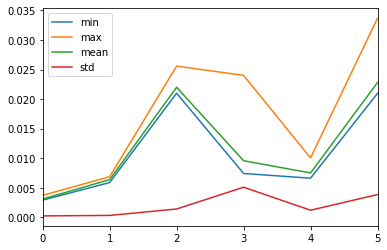

In [165]:
df = pd.DataFrame(outputs)
df.plot()

In [ ]:
for t in range(T):
    

In [61]:
output

[tensor(0.0003),
 tensor(0.0001),
 tensor(0.0002),
 tensor(0.0003),
 tensor(0.0002),
 tensor(0.0001),
 tensor(9.0346e-05),
 tensor(9.6604e-05),
 tensor(0.0009),
 tensor(0.0003)]

In [46]:
x_logits = torch.cat(preds)

i = 0
y = preds.copy()
del y[i]
y_logits = torch.cat(y)

In [57]:
MC_KL(x_logits,y_logits)

tensor(0.0242)

In [33]:
mask,_ = get_mask_preds(learn)
mask = torch.cat(mask)

In [42]:
u = torch.clamp(masks + mask,0,1).sum(dim=0)

In [43]:
i = (mask * masks).sum(dim=0)

In [48]:
i / u

tensor([0.4085, 0.4116, 0.4034, 0.3728, 0.4077])

In [34]:
masks = 

In [116]:
T = 10
mean = []
low = []
high = []
std = []

masks = []
preds = []
for t in range(T):
    mask,pred = get_mask_preds(learn,sample_model,ds_type=DatasetType.Fix)
    masks.append(mask)
    preds.append(pred)

In [117]:
kls(preds)

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [118]:
pred = torch.cat(preds)

In [123]:
n = 10000
pred = pred[:,:n,:]

In [130]:
mean_pred = pred.mean(dim=0,keepdim=True).expand(20,-1,-1)

In [158]:
x,y = data.one_batch()

for tfm in data.train_dl.tfms:
    x,y = tfm((x,y))
    

In [159]:
learn.model(x.cuda())

tensor([[ -3.8175,   5.3751,  -3.9777,  ...,  -3.7914,   5.6218,  -3.7429],
        [ 18.9034, -34.1240,  -5.1276,  ..., -24.8360,  -8.2155,  -0.3190],
        [-15.3342,  -6.2214,   1.4194,  ..., -17.0330,   2.5861,  -8.9764],
        ...,
        [  9.1765, -21.6155,  -2.8188,  ..., -10.4872,  -2.3215,   2.4392],
        [-15.7081,  -3.8299,  11.2177,  ...,  -1.8643,  -4.3008, -12.5930],
        [-23.8934, -10.1384,  -3.4591,  ...,  -7.4998,   2.7617,   3.9378]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [129]:
mean_pred * torch.log(mean_pred/diff)

torch.Size([20, 10000, 10])

In [32]:
def kl(ref_distribution,list_distributions):
    """Vectorized KL divergence between one distribution and a list of distributions
    
    Args:
        ref_distribution: A 1*N*C tensor with 
        list_distributions: A T*N*C tensor
        
    Returns:
    """
    
    log_ratio = torch.log(ref_distribution/list_distributions)
    
    prod = 
    
    kls = torch.einsum("tic,ic -> t",log_ratio,ref_distribution.squeeze(0))
    
    return kls

In [36]:
pred.shape

torch.Size([10, 40000, 10])

In [135]:
s = pred.sum(dim=0,keepdim=True).expand(T,-1,-1)

In [139]:
m = s / T

In [140]:
modified_m = (s - pred) / (T-1)

In [210]:
p_raws = []
T = 3

for t in range(T):
    p_raw,y = learn.get_preds(activ=activ)
    p_raw = p_raw[None]
    p_raws.append(p_raw)

In [ ]:
def MC_cross_entropy()

In [213]:
p_raws = torch.cat(p_raws)

In [218]:
logits_diff = p_raws - torch.logsumexp(p_raws,dim=2,keepdim=True)

In [224]:
log_mean_prob = torch.logsumexp(logits_diff,dim=0) - torch.log(torch.tensor(T).float())

In [228]:
mean_prob = torch.softmax(p_raws,dim=2).mean(dim=0)

In [229]:
(-mean_prob * log_mean_prob).sum()

tensor(1390.4841)

In [194]:
p = torch.softmax(p_raw,dim=1)

In [199]:
log_p = (p_raw - torch.logsumexp(p_raw,dim=1,keepdim=True))

In [208]:
F.log_softmax(p_raw,dim=1)

tensor([[-3.6759e+01, -2.8045e+01, -1.0623e+01,  ..., -2.7299e-05,
         -2.1733e+01, -1.3016e+01],
        [-1.0951e+01, -1.0318e+01, -3.1483e-01,  ..., -1.1896e+01,
         -1.3211e+00, -1.1653e+01],
        [-4.5585e+01, -1.8006e+01, -1.4096e+01,  ..., -1.8132e+01,
         -1.0083e+01, -1.5164e+01],
        ...,
        [-1.2989e+01, -1.8348e+01, -1.4768e+01,  ..., -8.6368e+00,
         -4.6091e+00, -1.0719e-02],
        [-2.6172e+01, -2.5133e+01, -2.5033e+01,  ..., -3.4497e+01,
          0.0000e+00, -3.0120e+01],
        [-3.3970e+01, -4.8533e+01, -4.0298e+01,  ..., -4.2024e+01,
         -2.3046e+01, -1.7140e+01]])

In [201]:
log_p.

tensor(-208.3708)

In [168]:
p = learn.model(x.cuda())

In [182]:
activ = Identity()

In [178]:
torch.softmax(p,dim=1)

tensor(0., device='cuda:0', grad_fn=<MinBackward1>)

In [145]:
(torch.log(m/modified_m) * m).sum(dim=2).max()

tensor(nan)

In [154]:
pred[0,0,:]

tensor(1.0000)

In [80]:
(torch.log(m / diff) * m).sum(dim=(2))

tensor([     inf,      inf,      inf,      inf,      inf,      inf,      inf,
             inf,      inf, 125.0027])

In [69]:
pred = torch.cat(preds).mean(dim=0)
accuracy(pred,y)

tensor(0.9265)

In [68]:
p,y = learn.get_preds(DatasetType.Fix)

In [51]:
for m in learn.model:
    if isinstance(m,DropLinear):
        m.remove_mask()

In [ ]:
n_iterations = 60

for i in range(n_iterations):
    scores = remove_lowest(masks,preds,kls,True)
    mean.append(scores.mean().item())
    low.append(scores.min().item())
    high.append(scores.max().item())
    std.append(scores.std().item())
    
    mask,pred = get_mask_preds(learn)
    masks.append(mask)
    preds.append(pred)

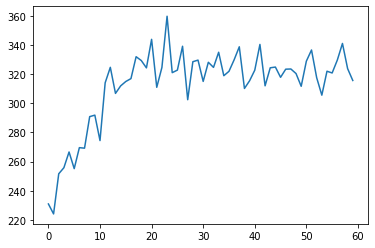

In [454]:
plt.plot(mean)

In [417]:
import itertools

In [457]:
p = torch.cat(preds).mean(dim=0)

In [458]:
accuracy(p,y)

tensor(0.9658)

In [427]:
_,y = learn.get_preds(DatasetType.Fix)

In [429]:
p,y = get_preds_sample(learn,DatasetType.Fix)

In [431]:
p = (p).mean(dim=0)

In [434]:
for m in learn.model:
    if isinstance(m,DropLinear):
        m.remove_mask()

In [437]:
learn.validate(learn.dl(DatasetType.Fix))

[0.12555529, tensor(0.9631)]

In [62]:
total = torch.zeros(1536,1)

for mask in masks:
    total += torch.cat(mask)

total = torch.clamp(total,0,1)

total.mean()

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [395]:
kls

tensor([39.3916, 32.5208, 41.0234, 61.9734, 45.3171, 76.7213, 58.6875, 59.2673,
        30.5528, 55.3150])

In [398]:
del preds[idx]

In [240]:
for tfm in learn.data.train_dl.tfms:
    x,y = tfm((x,y))

In [243]:
learn.model(x)

RuntimeError: Expected object of device type cuda but got device type cpu for argument #2 'mat1' in call to _th_addmm

In [217]:
l = DropLinear(20,10,0.5)

In [184]:
mask = l.sample()

In [185]:
l.set_mask(mask)

In [186]:
mask

tensor([[1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.]])

In [197]:
l.remove_mask()

In [141]:
import types

In [155]:
torch.is_nonzero(None)

TypeError: is_nonzero(): argument 'input' (position 1) must be Tensor, not NoneType

In [152]:
x = torch.randn(20)